In [1]:
import numpy
%matplotlib notebook
from matplotlib import pyplot

In [2]:
from soapy import atmosphere, WFS, confParse
from aotools import circle
from aotools.wfs import wfslib

In [3]:
SOAPY_CONF = "conf/test_conf.py"

In [10]:
# Initialise the WFS
config = confParse.Configurator(SOAPY_CONF)
config.loadSimParams()

config.tel.telDiam=1.
config.wfss[0].wavelength = 500e-9
config.atmos.scrnNo = 1

config.calcParams()

mask = circle.circle(config.sim.pupilSize/2., config.sim.simSize)

wfs = WFS.Gradient(
        config.sim, config.wfss[0], config.atmos, config.lgss[0], mask)

In [11]:
# Measure current pixel scale
maxTilt = 4 # arcsecs
tilts_asec = numpy.linspace(-maxTilt, maxTilt, 10)

tilts_rad = (tilts_asec/3600.) * (numpy.pi/180)
# Must convert arcsecs of tilt to amp in nm
tiltAmps = 1e9 * (tilts_rad * config.tel.telDiam/2.)# in nm amp

# Make a unit tilt to multiply
coords = numpy.linspace(-1, 1, config.sim.pupilSize)
coords = numpy.pad(coords, pad_width=[config.sim.simPad,]*2, mode="constant")
tilt = numpy.meshgrid(coords, coords)[0]

measuredTilts = numpy.zeros((tiltAmps.shape[0]))
for i, A in enumerate(tiltAmps):
    config.wfss[0].subapFOV = config.wfss[0].pxlsPerSubap
    wfs = WFS.Gradient(config.sim, config.wfss[0], config.atmos, config.lgss[0], mask)
    
    aTilt = tilt*A
    slopes = wfs.frame(aTilt)
    measuredTilts[i] = slopes[:wfs.activeSubaps].mean()
    
    # Check tilt is what I think it is
    dAmp = (aTilt.max() - aTilt.min())*1e-9
    angle = (dAmp/config.tel.telDiam) * (180./numpy.pi) * 3600

<IPython.core.display.Javascript object>


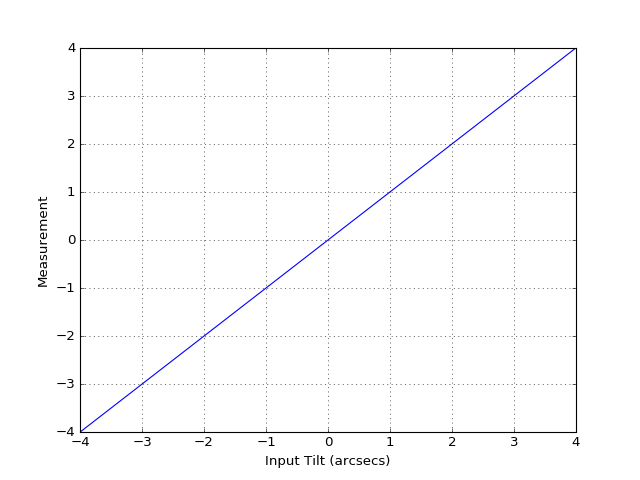

(-4, 4)

In [12]:
pyplot.figure()
pyplot.plot(tilts_asec, measuredTilts)
pyplot.grid()
pyplot.xlabel('Input Tilt (arcsecs)')
pyplot.ylabel('Measurement')
pyplot.ylim(-4,4)

In [14]:
# Make a set of phase screens to test
nScrns = 1000

NR0 = 10
R0s = numpy.linspace(0.05, 0.5, NR0)

In [15]:
slopes = numpy.zeros((NR0, nScrns, wfs.activeSubaps))
for ir0, r0 in enumerate(R0s):
    print('Test R0: {}'.format(r0))
    config.atmos.r0 = r0
    config.atmos.randomScrns = True
    atmos = atmosphere.atmos(config.sim, config.atmos)
    for i in range(nScrns):
        slopes[ir0, i] = wfs.frame(atmos.moveScrns())[:wfs.activeSubaps]

Test R0: 0.05
Test R0: 0.1
Test R0: 0.15
Test R0: 0.2
Test R0: 0.25
Test R0: 0.3
Test R0: 0.35
Test R0: 0.4
Test R0: 0.45
Test R0: 0.5


In [40]:
# Convert slopes to rad
slopes_rad = slopes * (1./3600) * (numpy.pi/180.)
# Measure r0 using slope variance
wvl = config.wfss[0].wavelength
# wvl = 600e-9
print("Wavelength (m): {}".format(wvl))
d = config.tel.telDiam/config.wfss[0].nxSubaps
print("Subap Diameter (m): {}".format(d))
measuredR0 = numpy.zeros(NR0)
for i in range(NR0):
    sVar = slopes_rad[i].var(0).mean()
    measuredR0[i] = ((0.162*(wvl**2) * d**(-1./3)) / sVar)**(3./5)

Wavelength (m): 5e-07
Subap Diameter (m): 0.125


<IPython.core.display.Javascript object>


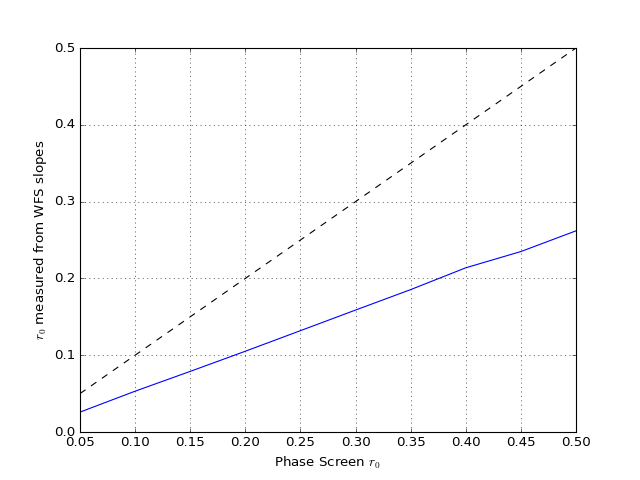

In [41]:
pyplot.figure()
pyplot.plot(R0s, measuredR0)
pyplot.plot(R0s, R0s, color="k", linestyle="--")
pyplot.grid()
pyplot.xlabel("Phase Screen $r_0$")
pyplot.ylabel("$r_0$ measured from WFS slopes")

In [21]:
measuredR0

array([  1.74935445e-08,   3.58694727e-08,   5.32780635e-08,
         7.09880047e-08,   8.90722489e-08,   1.07178468e-07,
         1.25148561e-07,   1.44324439e-07,   1.58607375e-07,
         1.76816663e-07])

In [36]:
wfs.xGrad.max()

0.0065000000000000006

In [37]:
slopes.max()

6.5237671019872039

In [38]:
slopes.min()

-6.6654630065917981

In [39]:
slopes_rad.min()

-3.2315076565252048e-05

In [26]:
slopes_rad[0].var(0).mean()

1.5184133236167461